In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v009.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch

import matplotlib.pyplot as plt
import tqdm

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/__init__.py


True

<IPython.core.display.Javascript object>


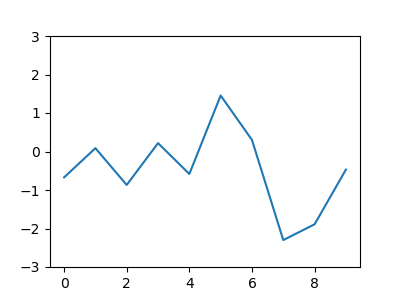

1
2
3
4
5
6
7
8
9
10


In [17]:
# test if GUI event loop is working
fig, ax = plt.subplots(figsize=(4,3))

data = np.random.randn(10)
line, = ax.plot(data)
ax.set_ylim(-3, 3)

try:
    for i in range(10):
        data = np.random.randn(10)
        line.set_ydata(data)
        fig.canvas.start_event_loop(1)
        fig.canvas.draw_idle()
        fig.canvas.flush_events()
        print(i+1)
except KeyboardInterrupt:
    print('Interrupt', file=sys.stderr)
    pass

In [18]:
# load the true wave image
data_root = '../data/BIOQIC'
wave_base = 'four_target_phantom.mat'
wave_file = data_root + '/' + wave_base
wave_data, _ = mre_pinn.data.load_mat_data(wave_file)

# convert to xarray and add metadata
u_true = wave_data['u_ft'].T
u_dims = ['frequency', 'component', 'z', 'x', 'y']
dx = 1e-3 # spatial resolution in meters
u_coords = {
    'frequency': np.linspace(50, 100, u_true.shape[0]), # Hz
    'x': np.arange(u_true.shape[3]) * dx,
    'y': np.arange(u_true.shape[4]) * dx,
    'z': np.arange(u_true.shape[2]) * dx,
    'component': ['y', 'x', 'z'],
}
u_true = xr.DataArray(u_true, dims=u_dims, coords=u_coords) * dx
u_true = u_true.transpose('frequency', 'x', 'y', 'z', 'component')

# downsampling
ds = 1
u_true = u_true.coarsen(x=ds, y=ds, z=ds).mean()

freq = 80
z = 0
y = 75 * dx

# single frequency 1D
#u_true = u_true.sel(frequency=[freq], y=y, z=z, component=['z'])

# single frequency 2D
u_true = u_true.sel(frequency=[freq], z=0, component=['z', 'y'])

# single frequency 3D
#u_true = u_true.sel(frequency=[freq], component=['x', 'y', 'z'])

# multifrequency 3D
#u_true = u_true.sel(component=['x', 'y', 'z'])

In [19]:
# load the true elastogram
elast_base = 'fem_box_ground_truth.npy'
elast_file = data_root + '/' + elast_base

print(f'Loading {elast_file}')
mu_true = np.load(elast_file)
print(mu_true.shape, mu_true.dtype)

# convert to xarray and add metadata
mu_dims = ['frequency', 'z', 'x', 'y']
mu_coords = {
    'frequency': np.linspace(50, 100, mu_true.shape[0]), # Hz
    'x': np.arange(mu_true.shape[2]) * dx,
    'y': np.arange(mu_true.shape[3]) * dx,
    'z': np.arange(mu_true.shape[1]) * dx,
}
mu_true = xr.DataArray(mu_true, dims=mu_dims, coords=mu_coords) # Pa
mu_true = mu_true.transpose('frequency', 'x', 'y', 'z')

# downsampling
mu_true = mu_true.coarsen(x=ds, y=ds, z=ds).mean()

# single frequency 1D
#mu_true = mu_true.sel(frequency=[freq], y=y, z=z)

# single frequency 2D
mu_true = mu_true.sel(frequency=[freq], z=z)

Loading ../data/BIOQIC/fem_box_ground_truth.npy
(6, 10, 80, 100) complex128


In [20]:
data = xr.Dataset(dict(u_true=u_true, mu_true=mu_true)) # not currently used
data

<xarray.Dataset>
Dimensions:    (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency  (frequency) float64 80.0
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
    z          float64 0.0
  * component  (component) <U1 'z' 'y'
Data variables:
    u_true     (frequency, x, y, component) complex128 (-4.219045827762767e-1...
    mu_true    (frequency, x, y) complex128 (3000+502.6548245743669j) ... (30...

<IPython.core.display.Javascript object>


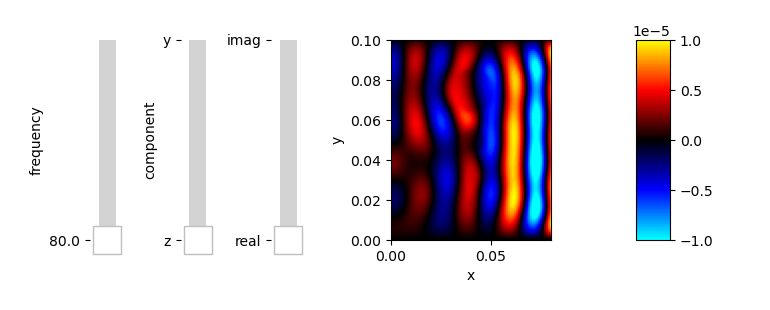

<IPython.core.display.Javascript object>


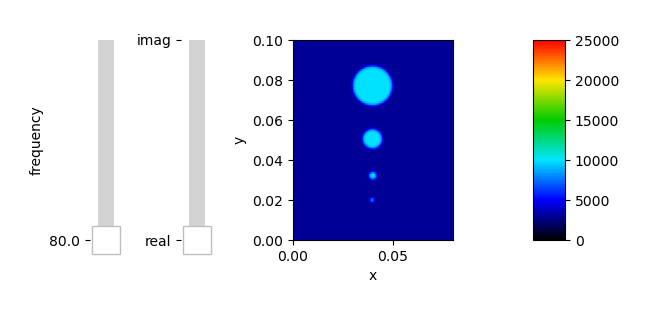

In [21]:
%autoreload

# display true wave field, elastogram, and direct inversion result
w_map = mre_pinn.visual.wave_color_map()
w_max = 1e-5
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

L_max = 1e-0
laplace_kws = dict(cmap=w_map, vmin=-L_max, vmax=L_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = 25e3
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=dx, dim=1)
Lu_true = xr.DataArray(Lu_true, dims=u_true.dims, coords=u_true.coords)

omega = u_true.frequency.to_numpy().reshape([(-1, 1)[i > 0] for i in range(u_true.ndim)])
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_true, Lu_true, omega)

mre_pinn.visual.NDArrayViewer(u_true,  **wave_kws)
#mre_pinn.visual.NDArrayViewer(Lu_true, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_Lu, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_true, **elast_kws)

In [22]:
%autoreload

batch_size = 1024 # training data points
num_domain = 1024 # PDE domain samples

# create point set boundary condition
bc = mre_pinn.data.NDArrayBC(u_true, batch_size=batch_size)
x = bc.points
x.shape, bc.values.shape, x.shape[0] / batch_size

((8000, 3), torch.Size([8000, 2]), 7.8125)

In [23]:
%autoreload

# set up PDE with geometry and boundary condition
wave_eq = mre_pinn.pde.WaveEquation(detach=True, homogeneous=False)

# for single frequency, we need to add eps to the geometry range to avoid zero volume
eps = np.zeros(x.shape[1])
eps[0] = 1e-5
geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + eps)

pde = deepxde.data.PDE(geometry, wave_eq, bc, num_domain=num_domain)
train_x = np.array(pde.train_x)
train_x.shape

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1026=1026. 
  warnings.warn("The balance properties of Sobol' points require "


(2048, 3)

In [24]:
%autoreload

# number of displacement components
n_u = u_true.shape[-1]
print(n_u)

# define model architecture
parallel = True
n_outputs = [n_u, 1] # u and mu
idxs = [0] + list(np.cumsum(n_outputs))

if parallel:
    net = mre_pinn.model.Parallel([
        mre_pinn.model.PINN(
            n_input=x.shape[1],
            n_layers=3,
            n_hidden=1024,
            n_output=n_output,
            activ_fn=torch.sin,
            complex=True,
            dense=True,
            omega0=8
        ) for n_output in n_outputs
    ])
else:
    net = mre_pinn.model.PINN(
        n_input=x.shape[1],
        n_layers=10,
        n_hidden=128,
        n_output=sum(n_outputs),
        activ_fn=torch.sin,
        complex=True,
        dense=False,
        omega0=64
    )
net

2


Parallel(
  (0): PINN(
    (linear0): Linear(in_features=3, out_features=1024, bias=True)
    (linear1): Linear(in_features=1027, out_features=1024, bias=True)
    (linear2): Linear(in_features=2051, out_features=4, bias=True)
  )
  (1): PINN(
    (linear0): Linear(in_features=3, out_features=1024, bias=True)
    (linear1): Linear(in_features=1027, out_features=1024, bias=True)
    (linear2): Linear(in_features=2051, out_features=2, bias=True)
  )
)

[-9.18317233e-08 -8.32130435e-07 -2.57747840e-09 -8.84057828e-09] [4.13009241e-06 4.55961511e-06 2.16911533e-07 2.90363821e-07]
[3.03666058e-02 3.33160220e-02 5.39079671e-05 1.15482443e-04] [0.32101207 0.37811829 0.01175451 0.01172924]
[3337.108373    502.65482457] [1.41813503e+03 8.08313416e-11]
(2048, 3) (2048, 4) (2048, 1)


<IPython.core.display.Javascript object>


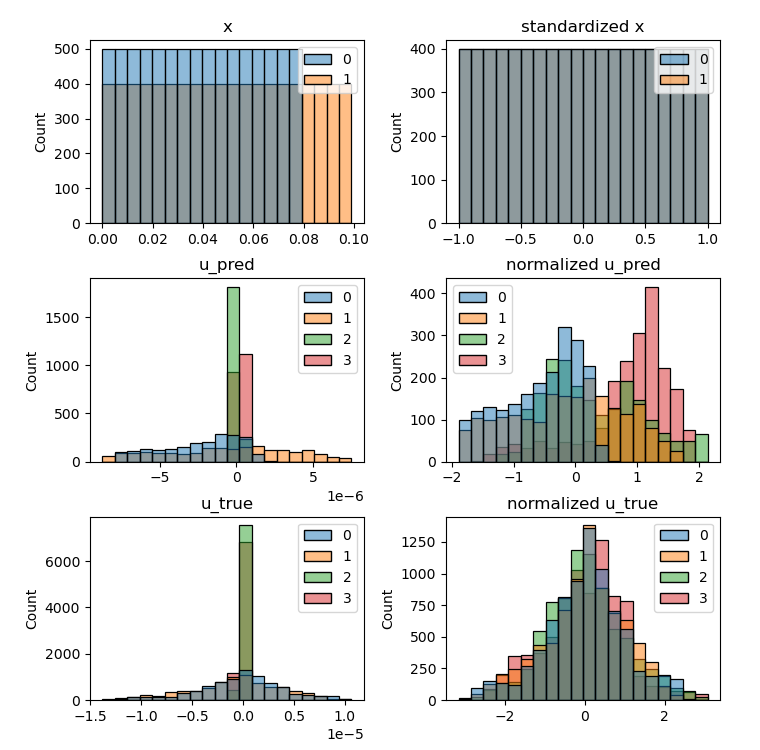

(2048, 4)

In [38]:
import seaborn as sns

# establish data and model weight distributions

# standardize inputs to [-1, 1]
x = bc.points
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

if x_scale[0] == 0: # avoid division by zero for single frequency
    x_scale[0] = 1

# normalize outputs with mean and std
u = mre_pinn.model.as_real(bc.values).cpu().numpy()
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)
print(u_loc, u_scale)

Lu = mre_pinn.discrete.laplacian(u_true, resolution=dx, dim=1).reshape(-1, n_u)
Lu = mre_pinn.model.as_real(torch.as_tensor(Lu)).cpu().numpy()
Lu_loc = np.mean(Lu, axis=0)
Lu_scale = np.std(Lu, axis=0)
print(Lu_loc, Lu_scale)

mu = torch.as_tensor(mu_true.to_numpy()).reshape(-1, 1)
mu = mre_pinn.model.as_real(mu).cpu().numpy()
mu_loc   = np.mean(mu, axis=0)
mu_scale = np.std(mu, axis=0)
print(mu_loc, mu_scale)

output_loc = np.append(u_loc, Lu_loc)
output_scale = np.append(u_scale, Lu_scale)

# initialize model weights
if parallel:
    net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=u_loc, output_scale=u_scale)
    net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=mu_loc, output_scale=mu_scale)
else:
    net.init_weights(input_loc=x_loc, input_scale=x_scale, output_loc=output_loc, output_scale=output_scale)
    print(output_loc.shape)

# plot distributions of model input and output

outputs = net.forward(torch.as_tensor(train_x).requires_grad_(False)).cpu().detach().numpy()
u_pred = outputs[:,idxs[0]:idxs[1]]
mu_pred = outputs[:,idxs[1]:idxs[2]]

u_pred = np.stack([u_pred.real, u_pred.imag], axis=-1).reshape(-1, 2*u_pred.shape[1])
print(outputs.shape, u_pred.shape, mu_pred.shape)

fig, axes = mre_pinn.visual.subplot_grid(3, 2, 2, 3, space=0.3, pad=[0.9, 0.4, 0.5, 0.4])

# x
axes[0,0].set_title('x')
axes[0,1].set_title('standardized x')
sns.histplot(x[:,1:], bins=20, label='x', ax=axes[0,0])
sns.histplot((x[:,1:] - x_loc[1:]) / x_scale[1:], bins=20, label='x', ax=axes[0,1])

# u_pred
axes[1,0].set_title('u_pred')
axes[1,1].set_title('normalized u_pred')
sns.histplot(u_pred[:,:], bins=20, ax=axes[1,0])
sns.histplot((u_pred[:,:] - u_loc[:1]) / u_scale[:], bins=20, ax=axes[1,1])

# u_true
axes[2,0].set_title('u_true')
axes[2,1].set_title('normalized u_true')
sns.histplot(u[:,:], bins=20, ax=axes[2,0])
sns.histplot((u[:,:] - u_loc[:]) / u_scale[:], bins=20, ax=axes[2,1])

u_pred.shape

In [42]:
%autoreload

# create normalized loss functions
u_norm = torch.norm(bc.values, dim=-1).mean().detach()
print(u_norm)

def normalized_L2_loss(norm):
    def loss_fn(y_true, y_pred):
        return torch.mean(
            torch.norm(y_true - y_pred, dim=-1) / norm
        )
    return loss_fn

loss = normalized_L2_loss(u_norm)

def predicted_L2_norm(idx, n):
    def norm(y_true, y_pred):
        return np.mean(
            np.linalg.norm(y_pred[:,idx:idx+n], axis=-1)
        )
    return norm

metrics = [predicted_L2_norm(idxs[i], n) for i, n in enumerate(n_outputs)]

def minibatch(func, batch_size):
    def wrapper(*args, **kwargs):
        n = args[0].shape[0]
        outputs = []
        for i in range(0, n, batch_size):
            batch_args = [a[i:i+batch_size] for a in args]
            output = func(*batch_args, **kwargs)
            outputs.append(output)
        return np.concatenate(outputs, axis=0)
    return wrapper

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1],
    loss=loss,
    metrics=metrics,
)
batch_predict = minibatch(model.predict, batch_size)
batch_size

tensor(5.3153e-06, dtype=torch.float64)
Compiling model...
'compile' took 0.000122 s



1024

Training model...



<IPython.core.display.Javascript object>


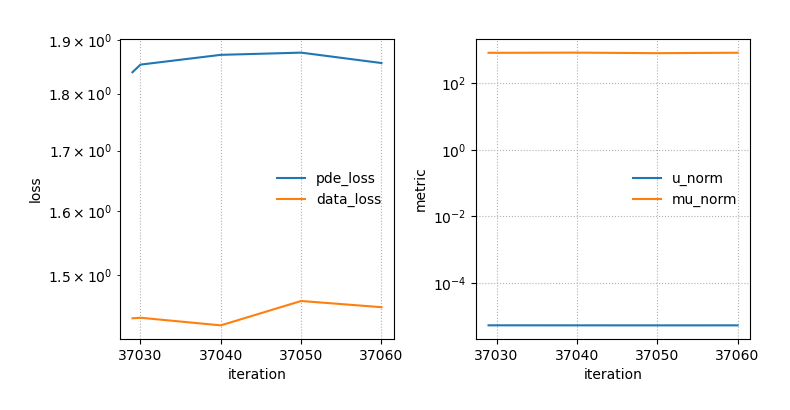

<IPython.core.display.Javascript object>


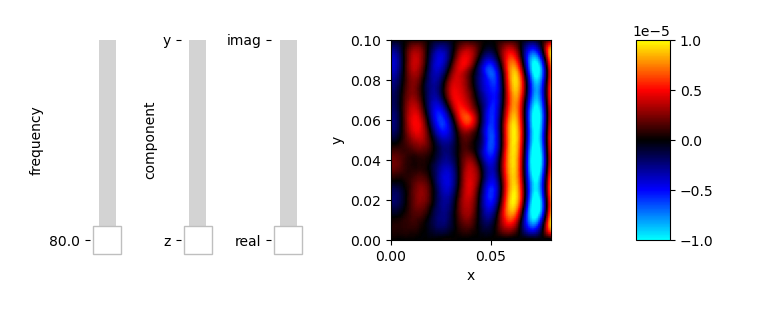

<IPython.core.display.Javascript object>


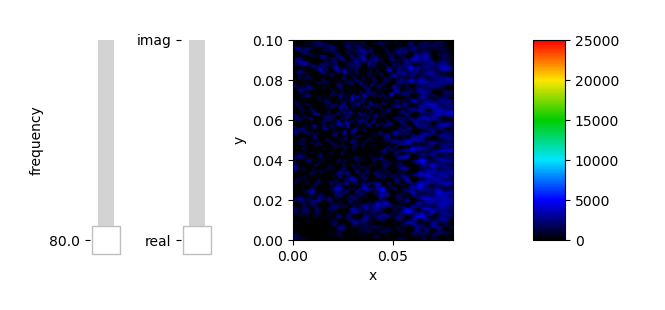

Interrupt


In [53]:
%autoreload

model.data.pde = mre_pinn.pde.WaveEquation(detach=True, homogeneous=False, incompressible=True)

deepxde.display.training_display = mre_pinn.visual.TrainingPlot(
    losses=['pde_loss', 'data_loss'], metrics=['u_norm', 'mu_norm']
)

class BatchResampler(deepxde.callbacks.Callback):

    def on_batch_end(self):
        self.model.data.train_x_bc = None
        self.model.data.resample_train_points()


class OutputViewer(deepxde.callbacks.Callback):
    
    def __init__(self, update_every):
        self.update_every = update_every
        super().__init__()

    def on_train_begin(self):
        outputs = self.model.predict(bc.points, callbacks=self.model.callbacks.callbacks)
        u_pred  = outputs[:,idxs[0]:idxs[1]].reshape(u_true.shape)
        mu_pred = outputs[:,idxs[1]:idxs[2]].reshape(mu_true.shape) * 2
        
        u_pred = xr.DataArray(u_pred, dims=u_true.dims, coords=u_true.coords)
        mu_pred = xr.DataArray(mu_pred, dims=mu_true.dims, coords=mu_true.coords)

        self.u_viewer  = mre_pinn.visual.NDArrayViewer(u_pred, **wave_kws)
        self.mu_viewer = mre_pinn.visual.NDArrayViewer(mu_pred, **elast_kws)
        model.net.train()

    def on_batch_end(self):
        i = self.model.train_state.step
        if i % self.update_every != 0:
            return

        outputs = self.model.predict(bc.points, callbacks=self.model.callbacks.callbacks)
        u_pred  = outputs[:,idxs[0]:idxs[1]].reshape(u_true.shape)
        mu_pred = outputs[:,idxs[1]:idxs[2]].reshape(mu_true.shape) * 2
        
        self.u_viewer.update_array(u_pred)
        self.mu_viewer.update_array(mu_pred)
        model.net.train()

try:
    model.train(1000000, display_every=10, callbacks=[BatchResampler(), OutputViewer(2)])
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)


In [48]:
def laplacian_u(x, outputs):
    u = outputs[:,idxs[0]:idxs[1]]
    lu = mre_pinn.pde.laplacian(u, x, dim=1)
    deepxde.gradients.clear()
    return lu

# model predictions
outputs = batch_predict(bc.points)
u_pred  = outputs[:,idxs[0]:idxs[1]].reshape(u_true.shape)
mu_pred = outputs[:,idxs[1]:idxs[2]].reshape(u_true.shape[:-1])
lu_pred = batch_predict(x, operator=laplacian_u).reshape(u_true.shape)

def xarray(a, like):
    return xr.DataArray(a, dims=like.dims, coords=like.coords)

u_pred  = xarray(u_pred, like=u_true)
lu_pred = xarray(lu_pred, like=u_true)
my_pred = xarray(mu_pred, like=mu_true)

<IPython.core.display.Javascript object>


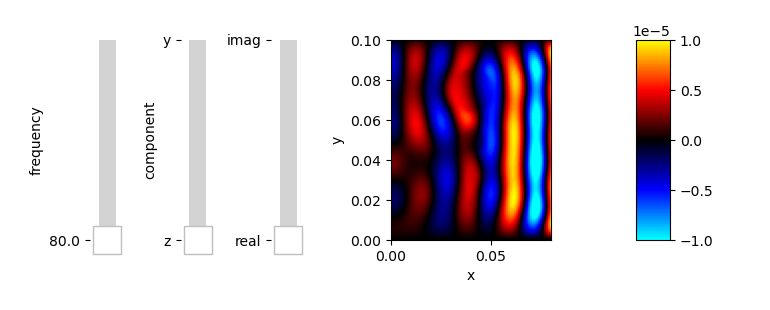

<IPython.core.display.Javascript object>


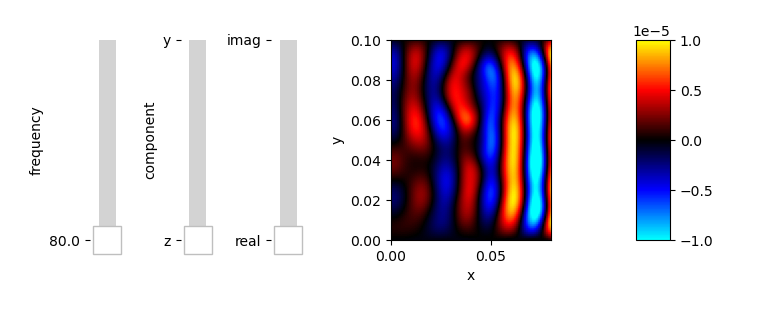

<IPython.core.display.Javascript object>


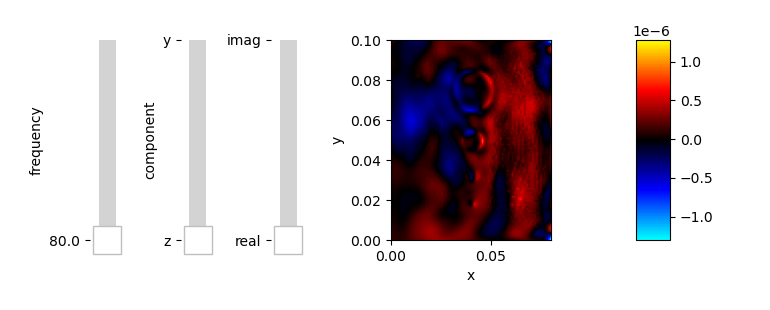

In [49]:
%autoreload

# display wave fields
mre_pinn.visual.NDArrayViewer(u_true, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_true - u_pred, cmap=w_map)

<IPython.core.display.Javascript object>


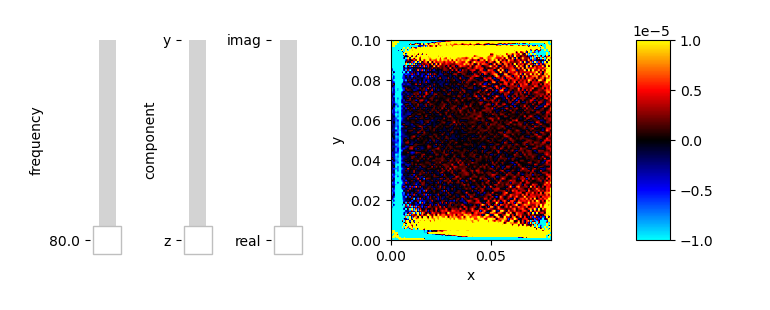

<IPython.core.display.Javascript object>


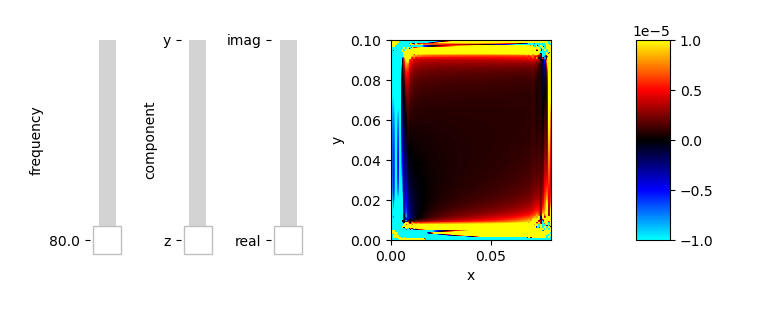

<IPython.core.display.Javascript object>


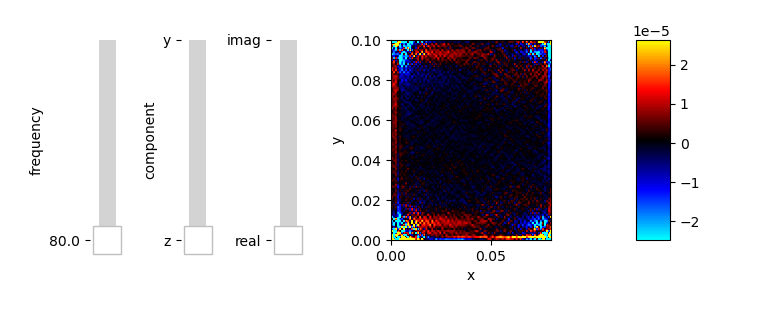

In [51]:
u_true_F = xarray(np.fft.fftn(u_true, axes=(1,2)), like=u_true)
u_pred_F = xarray(np.fft.fftn(u_pred, axes=(1,2)), like=u_pred)

mre_pinn.visual.NDArrayViewer(u_true_F, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_pred_F, **wave_kws)
mre_pinn.visual.NDArrayViewer(u_true_F - u_pred_F, cmap=w_map)

In [ ]:
# display wave field Laplacians

Lu_true = mre_pinn.discrete.laplacian(u_true, resolution=1e-3, dim=1)
Lu_pred = mre_pinn.discrete.laplacian(u_pred, resolution=1e-3, dim=1)

mre_pinn.visual.NDArrayViewer(Lu_true.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(Lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
mre_pinn.visual.NDArrayViewer(lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(Lu_pred.real - lu_pred.real, labels=u_true.dims, dpi=50/ds, cmap=w_map)
#mre_pinn.visual.NDArrayViewer(lu_model.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)
#mre_pinn.visual.NDArrayViewer(lu_model.real - lu_pred.real, labels=u_true.dims, dpi=50/ds, **laplace_kws)

In [ ]:
# display reconstructed elastograms

omega = u_true.frequency.to_numpy().reshape(-1, 1, 1)
mu_data = mre_pinn.discrete.helmholtz_inversion(u_true, Lu_true, omega) #.mean(axis=0)
mu_u_Lu = mre_pinn.discrete.helmholtz_inversion(u_pred, Lu_pred, omega) #.mean(axis=0)
mu_u_lu = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_pred, omega) #.mean(axis=0)
#mu_pred = mre_pinn.discrete.helmholtz_inversion(u_pred, lu_model, omega)

mre_pinn.visual.NDArrayViewer(mu_data.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_Lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
#mre_pinn.visual.NDArrayViewer(mu_u_lu.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_pred.real * 2, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)
mre_pinn.visual.NDArrayViewer(mu_true.real, labels=u_true.dims[0:-1], dpi=50/ds, **elast_kws)

#mre_pinn.visual.NDArrayViewer(mu_data.real - mu_pred.real, labels=u_true.dims[1:-1], dpi=50/ds, cmap=w_map)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
image = np.random.rand(3, 3)
img = ax.imshow(image)
axcolor = 'yellow'
ax_slider = plt.axes([0.20, 0.01, 0.65, 0.03], facecolor=axcolor)
slider = Slider(ax_slider, 'Slide->', 0.1, 30.0, valinit=2)
def update(val):
   ax.imshow(np.random.rand(3, 3))
   fig.canvas.draw_idle()
slider.on_changed(update)
plt.show()